<a href="https://colab.research.google.com/github/mizzmir/NLP/blob/master/Universal_sentence_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install adabelief-tf

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import seaborn as sns
from tqdm import tqdm
from adabelief_tf import AdaBeliefOptimizer

In [3]:
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def embed(input):
  return model(input)

In [4]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(corr, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  print("messages_ shape ", np.array(messages_).shape)
  print("embeddings shape ", message_embeddings_.shape)
  #plot_similarity(messages_, message_embeddings_, 90)

In [6]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [7]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)

(1, 2048, 512)


In [56]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, b'0'), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

https://colab.research.google.com/drive/1zvEzoT3NNUMXOtz901HPAxF1S7W_QZjy?usp=sharing

# Model

In [72]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [73]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [74]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [79]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    print("    attn_output shape ", attn_output.shape)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [93]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Dense(d_model, activation='elu')
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    print("before summing pos_encodding ", x.shape)
    x += self.pos_encoding[:, :seq_len, :]
    print("after summing pos_encodding ", x.shape)

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [97]:
class SequenceEmbeddingModel(tf.keras.Model):
  def __init__(self, num_steps, prefix):
    super().__init__()
    self.num_steps = num_steps
    self.prefix = prefix
    self.module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
    self.embeddings = hub.KerasLayer(self.module_url, trainable=True)
    self.concentrate = tf.keras.layers.Concatenate(axis=-1)
    self.reshape = tf.keras.layers.Reshape((self.num_steps, 512))
  def call(self, inputs):
    #print(self.prefix, " inputs: ", inputs)
    #print(self.prefix, " inputs shape ", inputs.shape)
    x = [self.embeddings(inputs[:, s]) for s in range(self.num_steps)]
    x = self.concentrate(x)
    #print(self.prefix, " after concentrate shape " ,x.shape)
    x = self.reshape(x)
    #print(self.prefix, " after reshape shape " ,x.shape)
    return x

class NumericalFeaturesEmbeddingModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    pass
  def call(self, inputs):
    pass

class ItemModel(tf.keras.Model):
  def __init__(self, num_steps=1):
    super().__init__()
    self.productNamesModel = SequenceEmbeddingModel(num_steps=num_steps, prefix="ItemModel.namesModel")
    self.categoryNamesModel = SequenceEmbeddingModel(num_steps=num_steps, prefix="ItemModel.categoriesModel")
    self.manufacturerNamesModel = SequenceEmbeddingModel(num_steps=num_steps, prefix="ItemModel.manufacturers")
    self.concentrate = tf.keras.layers.Concatenate(axis=-1)
    self.dense_layer = tf.keras.layers.Dense(1024, activation='elu')
    self.out_dense_1 = tf.keras.layers.Dense(512, activation='elu')
    self.out_dropout = tf.keras.layers.Dropout(0.3)
    self.out_dense_2 = tf.keras.layers.Dense(256, activation='elu')

  def call(self, inputs):
    names = inputs[0]
    categories = inputs[1]
    manufacturers = inputs[2]
    productNames_embeddings = self.productNamesModel(names)
    categoryNames_embeddings = self.categoryNamesModel(categories)
    manufacturerNames_embeddings = self.manufacturerNamesModel(categories)

    x = self.concentrate([names_embeddings, categories_embeddings])
    x = self.dense_layer(x)
    print("ItemModel after dense shape ", x.shape)
    x = self.out_dense_1(x)
    x = self.out_dropout(x)
    x = self.out_dense_2(x)
    print("ItemModel output shape ", x.shape)

    return x

class UserModel(tf.keras.Model):
  def __init__(self, num_steps):
    super().__init__()
    self.num_steps = num_steps
    self.productNamesModel = SequenceEmbeddingModel(num_steps=num_steps, prefix="ItemModel.namesModel")
    self.categoryNamesModel = SequenceEmbeddingModel(num_steps=num_steps, prefix="ItemModel.categoriesModel")
    self.manufacturerNamesModel = SequenceEmbeddingModel(num_steps=num_steps, prefix="ItemModel.manufacturers")
    self.concentrate = tf.keras.layers.Concatenate(axis=-1) # axis=-1
    self.dense_layer = tf.keras.layers.Dense(512, activation='elu')
    self.pos_encoding = positional_encoding(10000, 1024)
    self.gru_layer = tf.keras.layers.GRU(256, activation="tanh", dropout=0.0, recurrent_dropout=0.0)
    self.out_dense_1 = tf.keras.layers.Dense(256, activation='elu')
    self.out_dropout = tf.keras.layers.Dropout(0.3)
    self.out_dense_2 = tf.keras.layers.Dense(128, activation='elu')

    self.encoder_layer = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048,
                                  input_vocab_size=8500,
                                  maximum_position_encoding=10000)
    
  def create_masks(self, inp):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    return enc_padding_mask

  def call(self, inputs, training):
    """
    Wejscia do modelu:
      - productName seq
      - categoriesName seq

      DROBIC TO DATASETU:
      - idf seq
      - tfidf seq

      DOROBIC DO DATASETU:
      - whole prodName idf
      - whole categories idf

      - whole prodName seq embedding ?
      - whole categoriesName seq embedding ?

    """
    productNames = inputs[0]
    categoriesNames = inputs[1]
    manufacturers = inputs[2]
    names_embeddings = self.productNamesModel(productNames)
    categories_embeddings = self.categoryNamesModel(categoriesNames)
    manufacturerNames_embeddings = self.manufacturerNamesModel(manufacturers)

    print("names_embeddings: ", names_embeddings.shape)
    print("categories_embeddings: ", categories_embeddings.shape)
    print("manufacturerNames_embeddings: ", manufacturerNames_embeddings.shape)

    embeddings = self.concentrate([names_embeddings, categories_embeddings, manufacturerNames_embeddings])
    print("concentrated shape ", embeddings.shape)

    enc_padding_mask = self.create_masks(productNames)
    enc_output = self.encoder_layer(embeddings, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    print(enc_output.shape)

    #positional encodding
    """
    x *= tf.math.sqrt(tf.cast(512, tf.float32))
    print("x before positional encodding ", x.shape)
    x += self.pos_encoding[:, :self.num_steps, :]
    print("x with positional encodding ", x.shape)
    x = self.TransformerLayer(...)
    
    x = self.dense_layer(x)
    print("after dense shape ", x.shape)
    x = self.gru_layer(x)
    print("after GRU shape ", x.shape)
    x = self.out_dense_1(x)
    x = self.out_dropout(x)
    x = self.out_dense_2(x)
    print("output shape ", x.shape)
    """

    return x

# after model

In [82]:
user_model = UserModel(num_steps=6)
user_model.compile(optimizer="Adam")

item_model = ItemModel(num_steps=1)
item_model.compile(optimizer="Adam")

dataset = tf.data.Dataset.from_tensor_slices((x_test[1], x_test[2]))
for element in dataset.shuffle(100).batch(2).take(1):
  print("==========")
  print(element)
  x = user_model(element)
  print("")
  break

KeyboardInterrupt: ignored

In [ ]:
sns.set(rc={'figure.figsize':(50,50)})
dataset = tf.data.Dataset.from_tensor_slices(x_test[1])
for element in dataset.shuffle(100).batch(24).as_numpy_iterator():
  print("element shape ", element.shape)
  list_string = list(map(str, element))
  list_string = [ele.replace("b'0'", "") for ele in list_string]
  list_string = [ele.replace("_", " ") for ele in list_string]
  run_and_plot(list_string)
  break

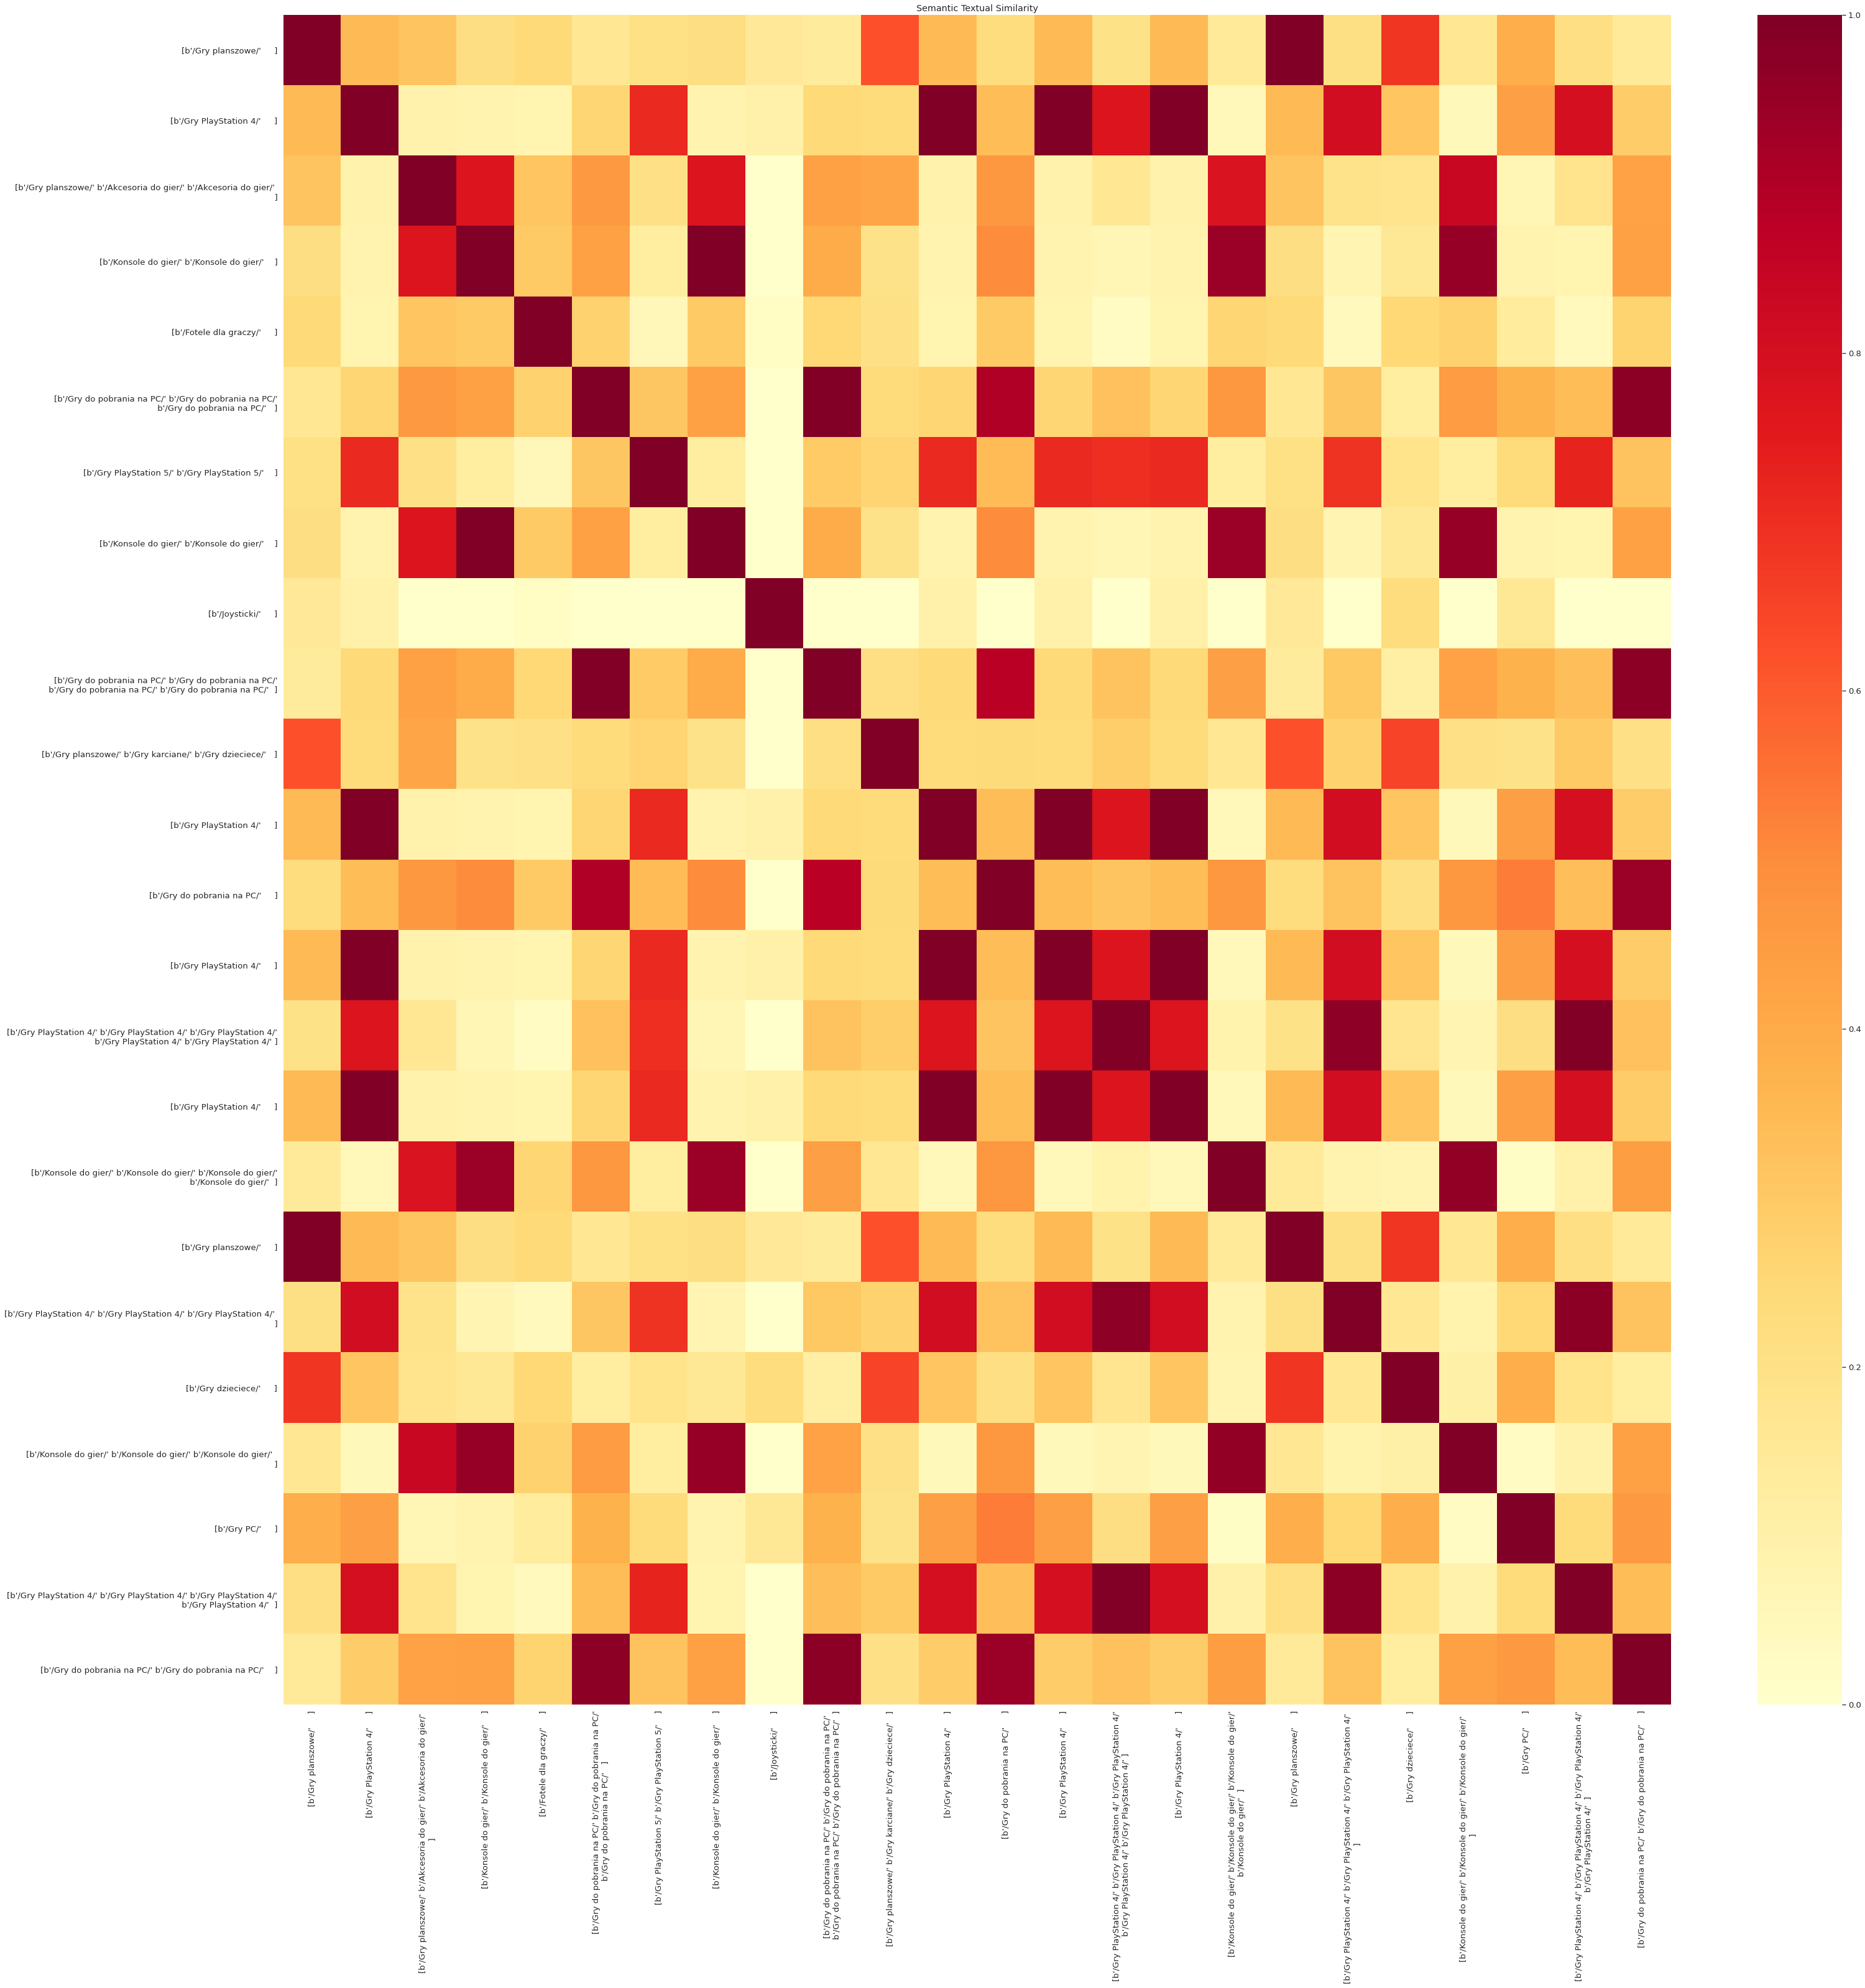

In [ ]:
sns.set(rc={'figure.figsize':(50,50)})
dataset = tf.data.Dataset.from_tensor_slices(x_test[2])
for element in dataset.shuffle(100).batch(24).as_numpy_iterator():
  list_string = list(map(str, element))
  list_string = [ele.replace("b'0'", "") for ele in list_string]
  list_string = [ele.replace("_", " ") for ele in list_string]
  run_and_plot(list_string)
  break

# Dataset to seq

In [9]:
import pandas as pd
import pprint

pd.set_option('display.max_colwidth', None)

df = pd.read_csv("/content/grytest_full_1_000db883cdac4caa98a010317ff9a0dd.csv", dtype={3:"str", 6:"str", 7:"str"})
print(df.shape)
df.dropna(inplace=True)
print(df.isna().sum())
df.drop_duplicates(subset=["product_NameNormalized", "client_VisitorGuid"], keep="last", inplace=True)
df.reset_index(inplace=True, drop=True)
df["product_NameNormalized"] = df["product_NameNormalized"].apply(lambda x: x.replace(" ", "___"))
df["product_Manufacturer"] = df["product_Manufacturer"].apply(lambda x: x.replace(" ", "___"))
print(df.info())
display(df.head())
print(df.shape)

(132, 9)
click_DateLocal           0
product_NameNormalized    0
client_VisitorGuid        0
product_Id                0
product_Category_Ids      0
product_Category_Names    0
product_Shops             0
product_LowestPrice       0
product_Manufacturer      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   click_DateLocal         94 non-null     object
 1   product_NameNormalized  94 non-null     object
 2   client_VisitorGuid      94 non-null     object
 3   product_Id              94 non-null     object
 4   product_Category_Ids    94 non-null     object
 5   product_Category_Names  94 non-null     object
 6   product_Shops           94 non-null     object
 7   product_LowestPrice     94 non-null     object
 8   product_Manufacturer    94 non-null     object
dtypes: object(9)
memory usage: 6.7+ KB
None


,click_DateLocal,product_NameNormalized,client_VisitorGuid,product_Id,product_Category_Ids,product_Category_Names,product_Shops,product_LowestPrice,product_Manufacturer
0,2021-08-27 22:00:05.0670000,kingdom___hearts___iii___(gra___xbox___one),6694e814-ab06-4b49-a0fa-4d40c9bb6669,28570119,"[470,2993,3525,3498]","[""Gry"",""Gry konsolowe"",""Gry Xbox"",""Gry Xbox One""]",14,39,Square___Enix
1,2021-08-27 22:00:08.1030000,microsoft___xbox___series___x,b82823ec-7833-4c5b-bbef-91215c7e9c65,88072703,"[470,534]","[""Gry"",""Konsole do gier""]",10,2399,Microsoft
2,2021-08-27 22:00:20.0670000,sid___meiers___civilization,1f523107-76a7-4e18-a6d3-5156ecac41aa,14122827,"[470,3955,1930]","[""Gry"",""Gry bez prądu"",""Gry planszowe""]",4,180.39,Galakta
3,2021-08-27 22:00:21.1900000,sony___playstation___5,a3251f3f-6cae-4ca0-9b0b-57edbd697672,86467784,"[470,534]","[""Gry"",""Konsole do gier""]",8,3299,Sony
4,2021-08-27 22:00:27.6330000,huzaro___force___6.0___red,548913b4-d92c-415d-be14-cb421717c444,83141097,"[470,1922,4030]","[""Gry"",""Akcesoria i kontrolery do gier"",""Fotele dla graczy""]",21,456,Huzaro


(94, 9)


In [10]:
cliend_ids = df.client_VisitorGuid.values
new_ids = []
for idx in range(len(cliend_ids)):
  new_ids.append(cliend_ids[idx%16])

df.client_VisitorGuid = new_ids

display(df.head(10))

,click_DateLocal,product_NameNormalized,client_VisitorGuid,product_Id,product_Category_Ids,product_Category_Names,product_Shops,product_LowestPrice,product_Manufacturer
0,2021-08-27 22:00:05.0670000,kingdom___hearts___iii___(gra___xbox___one),6694e814-ab06-4b49-a0fa-4d40c9bb6669,28570119,"[470,2993,3525,3498]","[""Gry"",""Gry konsolowe"",""Gry Xbox"",""Gry Xbox One""]",14,39,Square___Enix
1,2021-08-27 22:00:08.1030000,microsoft___xbox___series___x,b82823ec-7833-4c5b-bbef-91215c7e9c65,88072703,"[470,534]","[""Gry"",""Konsole do gier""]",10,2399,Microsoft
2,2021-08-27 22:00:20.0670000,sid___meiers___civilization,1f523107-76a7-4e18-a6d3-5156ecac41aa,14122827,"[470,3955,1930]","[""Gry"",""Gry bez prądu"",""Gry planszowe""]",4,180.39,Galakta
3,2021-08-27 22:00:21.1900000,sony___playstation___5,a3251f3f-6cae-4ca0-9b0b-57edbd697672,86467784,"[470,534]","[""Gry"",""Konsole do gier""]",8,3299,Sony
4,2021-08-27 22:00:27.6330000,huzaro___force___6.0___red,548913b4-d92c-415d-be14-cb421717c444,83141097,"[470,1922,4030]","[""Gry"",""Akcesoria i kontrolery do gier"",""Fotele dla graczy""]",21,456,Huzaro
5,2021-08-27 22:00:39.0970000,foxgames___lowcy___krysztalow,eee6ae46-391c-44b2-b118-c1be4c167d57,59830525,"[470,3955,1930]","[""Gry"",""Gry bez prądu"",""Gry planszowe""]",24,34.95,Foxgames
6,2021-08-27 22:00:43.9800000,hasbro___monopoly___junior___peppa___pig___f1656,c3282c97-4ecd-405f-8379-35a92fd68f64,104711426,"[470,3955,1055]","[""Gry"",""Gry bez prądu"",""Gry dziecięce""]",36,67,Hasbro
7,2021-08-27 22:00:48.3930000,"frahs___x7___plus___5,1""",47a80464-cce8-4522-9097-bb01bbef1dc5,92062218,"[470,534]","[""Gry"",""Konsole do gier""]",4,125.99,Frahs
8,2021-08-27 22:00:48.5830000,lego___worlds___(gra___ps4),506df0fc-f886-4316-a845-e8fd5e86ab4b,49235799,"[470,2993,1894,3499]","[""Gry"",""Gry konsolowe"",""Gry PlayStation"",""Gry PlayStation 4""]",14,64.9,Cenega
9,2021-08-27 22:00:53.2300000,hasbro___monopoly___lol___e7572,3a12e160-b191-4e17-b6a4-54278633490b,86388939,"[470,3955,1930]","[""Gry"",""Gry bez prądu"",""Gry planszowe""]",19,64.9,Hasbro


In [11]:
cols_vector = [col for col in df.columns if "product" in col]
pprint.pprint(f"Columns to create dict from {cols_vector}")

unique_vec_dict = {}
print("vocabs")

for col in cols_vector:
  unique_vec_dict[col] = list(df[col].unique())
  print(f"{col} --> {len(unique_vec_dict[col])}")

("Columns to create dict from ['product_NameNormalized', 'product_Id', "
 "'product_Category_Ids', 'product_Category_Names', 'product_Shops', "
 "'product_LowestPrice', 'product_Manufacturer']")
vocabs
product_NameNormalized --> 78
product_Id --> 78
product_Category_Ids --> 18
product_Category_Names --> 18
product_Shops --> 34
product_LowestPrice --> 76
product_Manufacturer --> 45


In [12]:
filtered_dates_seq = df.copy(deep=True)

seq_dfs = {}

for col in cols_vector:
  base_df = filtered_dates_seq.copy(deep=True)
  temp_df = base_df.groupby(["client_VisitorGuid"])[col].apply(" ".join).reset_index()
  seq_dfs[col] = temp_df
  display(temp_df.head())

,client_VisitorGuid,product_NameNormalized
0,03a23538-387b-4c60-bd2b-a01267887343,grid___2___(digital) sony___playstation___network___100___zl skup___zywca lucky___duck___games___kroniki___zbrodni___1400 thrustmaster___tca___sidestick___airbus___edition farming___simulator___22___edycja___kolekcjonerska___(gra___pc)
1,15dd84e9-c6f2-4f4a-b734-350775633d2f,spiace___krolewny dungeon___saga___grobowiec___krola___krasnoludow sony___playstation___4___slim___500gb___czarny sony___playstation___5___digital___edition portal___aeon's___end minecraft___java___edition___(digital)
2,1f523107-76a7-4e18-a6d3-5156ecac41aa,sid___meiers___civilization battlefield___2042___(gra___pc) europa___universalis___iv___(digital) sony___playstation___5 nintendo___switch___pro___controller___szary grand___theft___auto___san___andreas___(digital)
3,21e295df-49d2-414a-9921-9f4a5377383c,mario___kart___8___deluxe___(gra___ns) muduko___wirus___2___ewolucja marvel's___iron___man___vr___(gra___ps4) catan___(osadnicy___z___catanu) ace___combat___7___skies___unknown___(gra___ps4) mount___and___blade___ii___bannerlord___(digital)
4,2f3a13c6-7157-4c28-afd4-a74160d8bad2,star___wars:___x-wing___-___mysliwiec___tie/sf___(druga___edycja) trefl___ego___01298 sony___playstation___5 no___more___heroes___iii___(gra___ns) black___monk___zew___cthulhu___gra___paragrafowa___


,client_VisitorGuid,product_Id
0,03a23538-387b-4c60-bd2b-a01267887343,24082677 79507383 33179561 98737968 94823732 110414967
1,15dd84e9-c6f2-4f4a-b734-350775633d2f,40074691 42474150 47044569 96861968 70461419 47570063
2,1f523107-76a7-4e18-a6d3-5156ecac41aa,14122827 109852085 24053694 86467784 49566646 27654568
3,21e295df-49d2-414a-9921-9f4a5377383c,49566343 81611746 86618587 1719251 69232990 22507300
4,2f3a13c6-7157-4c28-afd4-a74160d8bad2,83651241 72288949 86467784 108083169 110243806


,client_VisitorGuid,product_Category_Ids
0,03a23538-387b-4c60-bd2b-a01267887343,"[470,3669,3476] [470,2477] [470,3955,1930] [470,3955,1930] [470,1922,1924] [470,3669,1897]"
1,15dd84e9-c6f2-4f4a-b734-350775633d2f,"[470,3955,3957] [470,3955,1930] [470,534] [470,534] [470,3955,1930] [470,3669,3476]"
2,1f523107-76a7-4e18-a6d3-5156ecac41aa,"[470,3955,1930] [470,3669,1897] [470,3669,3476] [470,534] [470,1922,1925] [470,3669,3476]"
3,21e295df-49d2-414a-9921-9f4a5377383c,"[470,2993,1892,4042] [470,3955,1055] [470,2993,1894,3499] [470,3955,1930] [470,2993,1894,3499] [470,3669,3476]"
4,2f3a13c6-7157-4c28-afd4-a74160d8bad2,"[470,3955,3956] [470,3955,1055] [470,534] [470,2993,1892,4042] [470,3955,3960]"


,client_VisitorGuid,product_Category_Names
0,03a23538-387b-4c60-bd2b-a01267887343,"[""Gry"",""Gry komputerowe"",""Gry do pobrania na PC""] [""Gry"",""Kody i karty pre-paid""] [""Gry"",""Gry bez prądu"",""Gry planszowe""] [""Gry"",""Gry bez prądu"",""Gry planszowe""] [""Gry"",""Akcesoria i kontrolery do gier"",""Joysticki""] [""Gry"",""Gry komputerowe"",""Gry PC""]"
1,15dd84e9-c6f2-4f4a-b734-350775633d2f,"[""Gry"",""Gry bez prądu"",""Gry karciane""] [""Gry"",""Gry bez prądu"",""Gry planszowe""] [""Gry"",""Konsole do gier""] [""Gry"",""Konsole do gier""] [""Gry"",""Gry bez prądu"",""Gry planszowe""] [""Gry"",""Gry komputerowe"",""Gry do pobrania na PC""]"
2,1f523107-76a7-4e18-a6d3-5156ecac41aa,"[""Gry"",""Gry bez prądu"",""Gry planszowe""] [""Gry"",""Gry komputerowe"",""Gry PC""] [""Gry"",""Gry komputerowe"",""Gry do pobrania na PC""] [""Gry"",""Konsole do gier""] [""Gry"",""Akcesoria i kontrolery do gier"",""Gamepady""] [""Gry"",""Gry komputerowe"",""Gry do pobrania na PC""]"
3,21e295df-49d2-414a-9921-9f4a5377383c,"[""Gry"",""Gry konsolowe"",""Gry Nintendo"",""Gry Nintendo Switch""] [""Gry"",""Gry bez prądu"",""Gry dziecięce""] [""Gry"",""Gry konsolowe"",""Gry PlayStation"",""Gry PlayStation 4""] [""Gry"",""Gry bez prądu"",""Gry planszowe""] [""Gry"",""Gry konsolowe"",""Gry PlayStation"",""Gry PlayStation 4""] [""Gry"",""Gry komputerowe"",""Gry do pobrania na PC""]"
4,2f3a13c6-7157-4c28-afd4-a74160d8bad2,"[""Gry"",""Gry bez prądu"",""Gry figurkowe i bitewne""] [""Gry"",""Gry bez prądu"",""Gry dziecięce""] [""Gry"",""Konsole do gier""] [""Gry"",""Gry konsolowe"",""Gry Nintendo"",""Gry Nintendo Switch""] [""Gry"",""Gry bez prądu"",""Gry fabularne RPG""]"


,client_VisitorGuid,product_Shops
0,03a23538-387b-4c60-bd2b-a01267887343,10 17 2 23 22 11
1,15dd84e9-c6f2-4f4a-b734-350775633d2f,38 4 5 11 43 9
2,1f523107-76a7-4e18-a6d3-5156ecac41aa,4 20 12 8 19 13
3,21e295df-49d2-414a-9921-9f4a5377383c,13 22 18 67 14 12
4,2f3a13c6-7157-4c28-afd4-a74160d8bad2,7 40 8 3 8


,client_VisitorGuid,product_LowestPrice
0,03a23538-387b-4c60-bd2b-a01267887343,11.52 85.87 39.5 67.88 306.21 309
1,15dd84e9-c6f2-4f4a-b734-350775633d2f,26.19 125.09 1326.5 2449 99.28 73.8
2,1f523107-76a7-4e18-a6d3-5156ecac41aa,180.39 213 15.28 3299 248.99 12.96
3,21e295df-49d2-414a-9921-9f4a5377383c,199 19.29 76.99 90.92 74.9 119.5
4,2f3a13c6-7157-4c28-afd4-a74160d8bad2,29 50 3299 225 24.86


,client_VisitorGuid,product_Manufacturer
0,03a23538-387b-4c60-bd2b-a01267887343,Codemasters Sony Foxgames Lucky___Duck ThrustMaster Focus___Home___Interactive
1,15dd84e9-c6f2-4f4a-b734-350775633d2f,Rebel Bard Sony Sony Portal___Games Microsoft
2,1f523107-76a7-4e18-a6d3-5156ecac41aa,Galakta EA___Games Paradox___Interactive Sony Nintendo Rockstar___Games
3,21e295df-49d2-414a-9921-9f4a5377383c,Nintendo Muduko Sony Galakta Cenega TaleWorlds
4,2f3a13c6-7157-4c28-afd4-a74160d8bad2,Rebel Trefl Sony Nintendo Black___Monk___Games


In [13]:
for item in seq_dfs.items():
  df[f"seq_{item[0]}"] = filtered_dates_seq['client_VisitorGuid'].map(item[1].set_index('client_VisitorGuid')[item[0]])

In [14]:
df.drop_duplicates(subset=['client_VisitorGuid'], inplace=True)
print(df.shape)

(16, 16)


In [15]:
all_seq_cols = [col for col in df.columns if "seq" in col]
print(all_seq_cols)

['seq_product_NameNormalized', 'seq_product_Id', 'seq_product_Category_Ids', 'seq_product_Category_Names', 'seq_product_Shops', 'seq_product_LowestPrice', 'seq_product_Manufacturer']


In [16]:
df.to_csv("/content/preprocessed_df.csv", index=False)

# Dataset creation code

In [20]:
from abc import ABC, abstractmethod
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from sklearn.model_selection import train_test_split


In [25]:

class Dataset(ABC):
    def __init__(self):
        self.train = None
        self.test = None
        self.tf_candidates = None
        
    def build_tf_dataset(self, k=1, min_length=1, window_step=1):
        """
        Builds tensorflow dataset from the data
        """
        print('> Building tensorflow datasets.')
        if (self.train is None or self.test is None):
            raise Exception('You must execute split before building the tensorflow dataset.')

        print('>> Building training dataset. This process may take a long time.')
        self.tf_train = self._build_dataset(self.train, self.sequence_length, k, min_length, window_step)

        print('>> Building testing dataset. This process may take a long time.')
        self.tf_test = self._build_dataset(self.test, self.sequence_length, k, min_length, window_step)

        print('>> Tensorflow datasets built.')
    
    def _build_dataset(self, data, seq_len, k, min_length, window_step):
        """
        Uses a sliding window strategy for building the dataset.
        """
        prodId_ds = []
        prodName_ds = []
        CatId_ds = []
        CatName_ds = []
        shops_ds = []
        lowestPrice_ds = []
        manufacturer_ds = []
        labels = []

        bert_prodId_ds = []
        bert_prodName_ds = []
        bert_CatId_ds = []
        bert_CatName_ds = []
        bert_shops_ds = []
        bert_lowestPrice_ds = []
        bert_manufacturer_ds = []

        data_id = np.array([np.array(t.split(' ')) for t in data["seq_product_Id"]], dtype=object)
        data_name = np.array([np.array([e_t.replace("___", " ") for e_t in t.split(' ')]) for t in data["seq_product_NameNormalized"]], dtype=object)

        data_catId = np.array([np.array(t.split(' ')) for t in data["seq_product_Category_Ids"]], dtype=object)
        data_catName = np.array([np.array([e_t.replace("___", " ") for e_t in t.split(' ')]) for t in data["seq_product_Category_Names"]], dtype=object)

        data_shops = np.array([np.array(t.split(' ')) for t in data["seq_product_Shops"]], dtype=object)

        data_price = np.array([np.array(t.split(' ')) for t in data["seq_product_LowestPrice"]], dtype=object)

        data_manufacturer = np.array([np.array([e_t.replace("___", " ") for e_t in t.split(' ')]) for t in data["seq_product_Manufacturer"]], dtype=object)
        
        pbar = tqdm(range(data.shape[0]), total=data.shape[0])
        for j in pbar:

            prodIds = data_id[j]
            prodNames = data_name[j]

            catIds = data_catId[j]
            catNames = data_catName[j]

            shops = data_shops[j]

            prices = data_price[j]

            manufacturers = data_manufacturer[j]
            
            for i in range(0, len(prodIds) - min_length, window_step):
                start = max(0, i - self.sequence_length)
                end = i + min_length
                #print(f"start {start} | end {end}")
                
                prodId_ds.append(prodIds[start:end])
                prodName_ds.append(prodNames[start:end])
                
                CatId_ds.append(catIds[start:end])
                CatName_ds.append(catNames[start:end])

                shops_ds.append(shops[start:end])
                lowestPrice_ds.append(prices[start:end])
                manufacturer_ds.append(manufacturers[start:end])

                bert_prodId_ds.append(prodIds[start:(end+1)])
                bert_prodName_ds.append(prodNames[start:(end+1)])
                
                bert_CatId_ds.append(catIds[start:(end+1)])
                bert_CatName_ds.append(catNames[start:(end+1)])

                bert_shops_ds.append(shops[start:(end+1)])
                bert_lowestPrice_ds.append(prices[start:(end+1)])
                bert_manufacturer_ds.append(manufacturers[start:(end+1)])
                
                labels.append(prodIds[end])
                pbar.set_description(f"Current size {len(prodId_ds)}")

        padded_prodId_ds = pad_sequences(prodId_ds, maxlen=seq_len, padding='post')
        padded_prodName_ds = pad_sequences(prodName_ds, maxlen=seq_len, dtype=object, value='0', padding='post')
        padded_CatId_ds = pad_sequences(CatId_ds, maxlen=seq_len, dtype=object, value='0', padding='post')
        padded_CatName_ds = pad_sequences(CatName_ds, maxlen=seq_len, dtype=object, value='0', padding='post')
        padded_shops_ds = pad_sequences(shops_ds, maxlen=seq_len, padding='post')
        #lowestPrice_ds = pad_sequences(lowestPrice_ds, maxlen=seq_len, padding='post')
        padded_manufacturer_ds = pad_sequences(manufacturer_ds, maxlen=seq_len, dtype=object, value='0', padding='post')

        return ((prodId_ds, prodName_ds, CatId_ds, CatName_ds, shops_ds, manufacturer_ds), 
                (padded_prodId_ds, padded_prodName_ds, padded_CatId_ds, padded_CatName_ds, padded_shops_ds, padded_manufacturer_ds), 
                (bert_prodId_ds, bert_prodName_ds, bert_CatId_ds, bert_CatName_ds, bert_shops_ds, bert_manufacturer_ds), 
                np.array(labels))
    
    def save_arrays(self):
        x_train, x_train_padded, y_train_bert, y_train = self.tf_train
        x_test, x_test_padded,  y_test_bert, y_test = self.tf_test
        
        """
        np.save(f"{BASE_PATH}/preprocessed_seq_arrays/x_train_2_10_clicks_hist{self.sequence_length}_phones.npy", x_train)
        np.save(f"{BASE_PATH}/preprocessed_seq_arrays/y_train_2_10_clicks_hist{self.sequence_length}_phones.npy", y_train)

        np.save(f"{BASE_PATH}/preprocessed_seq_arrays/x_test_2_10_clicks_hist{self.sequence_length}_phones.npy", x_test)
        np.save(f"{BASE_PATH}/preprocessed_seq_arrays/y_test_2_10_clicks_hist{self.sequence_length}_phones.npy", y_test)
        """

        SAVE_PATH = f"{BASE_PATH}/preprocessed_seq_arrays/history_{self.sequence_length}"
        Path(SAVE_PATH).mkdir(parents=True, exist_ok=True)
        print("Saving to ", SAVE_PATH)
        
        np.save(f"{SAVE_PATH}/x_train_hist{self.sequence_length}.npy", x_train)
        np.save(f"{SAVE_PATH}//y_train_hist{self.sequence_length}.npy", y_train)

        np.save(f"{SAVE_PATH}//x_train_padded_hist{self.sequence_length}.npy", x_train_padded)
        np.save(f"{SAVE_PATH}//y_train_bert_hist{self.sequence_length}.npy", y_train_bert)

        np.save(f"{SAVE_PATH}//x_test_hist{self.sequence_length}.npy", x_test)
        np.save(f"{SAVE_PATH}//y_test_hist{self.sequence_length}.npy", y_test)

        np.save(f"{SAVE_PATH}//x_test_padded_hist{self.sequence_length}.npy", x_test_padded)
        np.save(f"{SAVE_PATH}//y_test_bert_hist{self.sequence_length}.npy", y_test_bert)

    def candidates(self):
        if (self.tf_candidates is not None): return self.tf_candidates
        print('> Retrieving candidates. This process takes more time as the number of unique items increases.')
        if (len(self.vocab_set) == 0):
            raise Exception('Execute load before querying the candidates.')
        np_candidates = list(self.vocab_set)
        tf_candidates = tf.data.Dataset.from_tensor_slices(np_candidates)
        self.tf_candidates = tf_candidates
        return self.tf_candidates

    def _create_vocab(self):
        # prodId vocab
        vocab = list(self.vocab_set)
        self.vocab = StringLookup(vocabulary=vocab)
        self.num_items = self.vocab.vocab_size()

        # catId vocab
        #vocab = list(self.catId_vocab_set)
        #self.catId_vocab = StringLookup(vocabulary=vocab)
        # self.num_items_catId = self.catId_vocab.vocab_size()

        # num_users
        self.num_users = len(self.df)

    @abstractmethod
    def load(self):
        """
        Loads processed dataset
        """
        raise NotImplementedError

    @abstractmethod
    def pipeline(self):
        """
        Executes the entire pipeline that makes the data ready to run.
        """
    
    @abstractmethod
    def preprocess(self):
        """
        Applies preprocessing in the dataset, transforming
        to a format compatible with this module.
        """
        raise NotImplementedError

    @abstractmethod
    def split(self):
        """
        Splits the dataset in train and test splits
        """
        raise NotImplementedError

class CeneoRecoDataset(Dataset):   
    def __init__(self, input_csv_path, prodId_vocab_file_path, catId_vocab_file_path, override=False, use_sample=1, seq_length=20):
        """
        Use sample represents the fraction of the dataset that should be
        used. 1 means 100%
        """
        super().__init__()
        self.use_sample = use_sample
        self.sequence_length = seq_length
        self.input_csv_path = input_csv_path
        self.prodId_vocab_file_path = prodId_vocab_file_path
        self.catId_vocab_file_path = catId_vocab_file_path

    def load(self):
        print('> Loading dataset.')
        self.df = pd.read_csv(self.input_csv_path)
        """if (len(self.vocab_set) == 0):
            lines = pd.read_csv(self.prodId_vocab_file_path, header=None)
            self.vocab_set = set(lines[0].astype('str'))"""
        """if (len(self.catId_vocab_set) == 0):
            lines = pd.read_csv(self.catId_vocab_file_path, header=None)
            self.catId_vocab_set = set(lines[0].astype('str'))"""
        
        print('>> Dataset loaded. Creating vocabulary.')
        #self._create_vocab()
        #print(f'>> Vocabulary of size {self.vocab.vocab_size()} created. Dataset is ready.')

    def pipeline(self, split_params={}):
        self.preprocess()
        self.load()
        self.split(**split_params)
        self.build_tf_dataset()
        #self.save_arrays()

    def preprocess(self):
        pass

    def split(self, test_size=0.2, shuffle=False):
        print('> Splitting dataset')
        print(f'>> Sampling {int(self.use_sample * 100)}% of dataset')
        sample = self.df if (self.use_sample == 1) else self.df.sample(frac=self.use_sample)

        print(f'>> Splitting sample with {int(test_size * 100)}% for testing')
        train, test = train_test_split(sample[['seq_product_NameNormalized', 'seq_product_Id', 'seq_product_Category_Ids', 'seq_product_Category_Names', 'seq_product_Shops', 'seq_product_LowestPrice', 'seq_product_Manufacturer']], test_size=test_size, shuffle=shuffle)

        self.train = train
        self.test=test

In [26]:
dataset = CeneoRecoDataset(input_csv_path="/content/preprocessed_df.csv", 
                           prodId_vocab_file_path=f'vocabs/productId_vocab_clicks.txt',
                           catId_vocab_file_path=f'vocabs/categoryName_vocab_clicks.txt', 
                           seq_length=6, 
                           use_sample=1)
dataset.pipeline()

> Loading dataset.
>> Dataset loaded. Creating vocabulary.
> Splitting dataset
>> Sampling 100% of dataset
>> Splitting sample with 20% for testing
> Building tensorflow datasets.
>> Building training dataset. This process may take a long time.


Current size 60: 100%|██████████| 12/12 [00:00<00:00, 82.97it/s]


>> Building testing dataset. This process may take a long time.


Current size 18: 100%|██████████| 4/4 [00:00<00:00, 157.28it/s]

>> Tensorflow datasets built.


In [27]:
x_train, x_train_padded, y_train_bert, y_train = dataset.tf_train

In [35]:
prodId_ds, prodName_ds, CatId_ds, CatName_ds, shops_ds, manufacturer_ds = x_train_padded

In [58]:
prodName_ds[0]

array(['kingdom hearts iii (gra xbox one)', '0', '0', '0', '0', '0'],
      dtype=object)

In [62]:
create_padding_mask(prodName_ds[0:3])

<tf.Tensor: shape=(3, 1, 1, 6), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1., 1.]]],


       [[[0., 0., 1., 1., 1., 1.]]],


       [[[0., 0., 0., 1., 1., 1.]]]], dtype=float32)>

# Run model

In [98]:
user_model = UserModel(num_steps=6)
user_model.compile(optimizer=AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False))

dataset_tf = tf.data.Dataset.from_tensor_slices((prodName_ds, CatName_ds, manufacturer_ds))
for element in dataset_tf.batch(2).take(1):
  print("==========")
  print(element)
  x = user_model(element)
  print("output shape ", x.shape)
  break

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.1)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

(<tf.Tensor: shape=(2, 6), dtype=string, numpy=
array([[b'kingdom hearts iii (gra xbox one)', b'0